# Predicting tips

In this notebook, we consider the following:

> Can we predict how much tip a driver will get based on the conditions of a trip?

## Classification problem: will the trip get tipped?

We wish to predict whether or not a trip gets tipped, using classification models. We take a measured approach, first considering logistic regression with univariate analysis, and then combining strong predictors using `xgboost`.

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import numpy as np
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [123]:
date_ptr = '2009-01'
data_arr = []

while date_ptr != '2024-01':
    date_data = pd.read_parquet(f'../data/tr_data/{date_ptr}.parquet')
    data_arr.append(date_data)
    date_ptr = (pd.to_datetime(date_ptr) + pd.DateOffset(months=1)).strftime('%Y-%m')

data_df = pd.concat(data_arr)

### Univariate analysis

One thing to note is that we won't know how long the trip will be before the trip ends, so we can't use this as this has lookahead bias.

#### Trip distance as a predictor for tip amount

Text(0.5, 0, 'Trip distance (miles)')

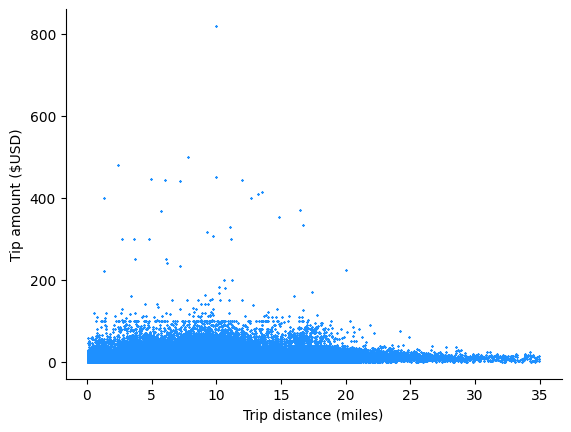

In [102]:
plt.scatter(data_df['trip_distance'], data_df['tip_amount'], marker='x', s=1, color='dodgerblue')
sns.despine()
plt.ylabel('Tip amount ($USD)')
plt.xlabel('Trip distance (miles)')

Text(0.5, 0, 'Trip distance(miles)')

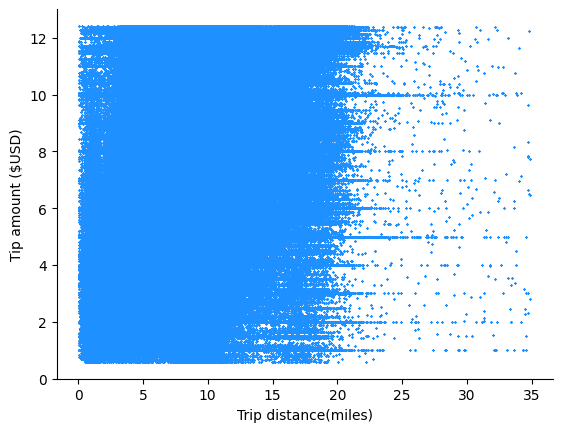

In [124]:
data_df['tip_amount_zscore'] = stats.zscore(data_df['tip_amount'])
no_outliers = data_df[abs(data_df['tip_amount_zscore']) < 2].copy()

plt.scatter(no_outliers['trip_distance'], no_outliers['tip_amount'], marker='x', s=1, color='dodgerblue')
sns.despine()
plt.ylabel('Tip amount ($USD)')
plt.xlabel('Trip distance(miles)')

The above is obviously quite hard to see, as there is so many data points, so we'll bucket and see if there exists any relationship at the mean level.

Text(0, 0.5, 'Mean tip amount ($USD)')

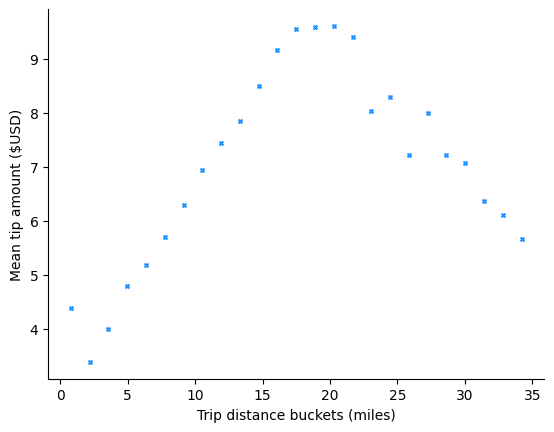

In [103]:
no_outliers['trip_distance_bucket'] = pd.cut(no_outliers['trip_distance'], 25).apply(lambda x: (x.left + x.right) / 2)
no_outliers_mean = no_outliers.groupby('trip_distance_bucket', observed=False)['tip_amount'].mean()

plt.scatter(no_outliers_mean.index, no_outliers_mean, marker='x', s=8, color='dodgerblue')
sns.despine()
plt.xlabel('Trip distance buckets (miles)')
plt.ylabel('Mean tip amount ($USD)')

There exists a strong linear relationship from `0 -> 20` miles, but then this reverts down. We use `xgboost` to fit a tree on the whole data set.

In [125]:
X = no_outliers[['trip_distance']]
y = no_outliers['tip_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

We test different learning rates, using mean absolute error.

In [105]:
for lr in [0.001, 0.01, 0.1, 0.3, 0.5]:
    model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=4,
    learning_rate=lr,
    objective='reg:squarederror',
    random_state=42
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Learning rate: {lr}\t|\tMAE: {mae}')

Learning rate: 0.001	|	MAE: 1.7606927781907733
Learning rate: 0.01	|	MAE: 1.5837253754899472
Learning rate: 0.1	|	MAE: 1.5197685502154896
Learning rate: 0.3	|	MAE: 1.5197513190293719
Learning rate: 0.5	|	MAE: 1.51978275932583


We use a learning rate of 0.1; the mean absolute error between 0.1, 0.3 and 0.5 are extremely close.

In [92]:
final_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    objective='reg:squarederror',
    random_state=42
)
final_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

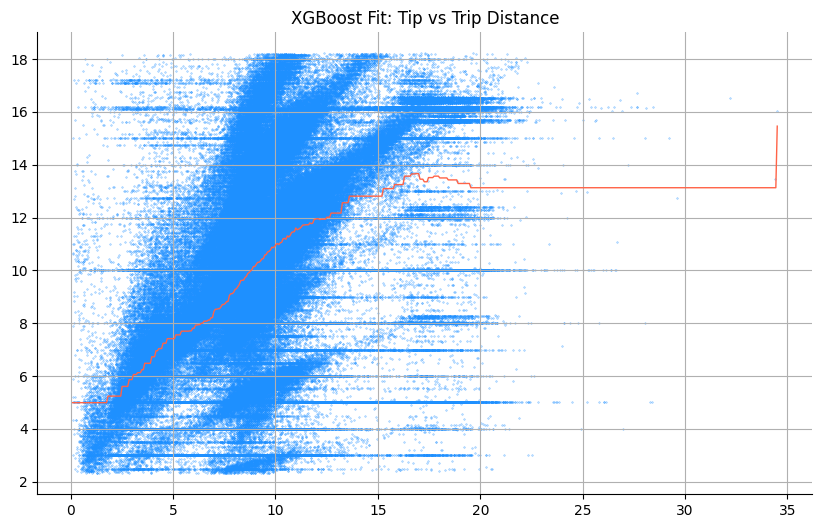

In [96]:
x_line = np.linspace(X['trip_distance'].min(), X['trip_distance'].max(), 500).reshape(-1, 1)
y_pred_line = final_model.predict(x_line)

plt.figure(figsize=(10, 6))
plt.scatter(X['trip_distance'], y, marker='x', s=1, alpha=0.3, color='dodgerblue')
plt.plot(x_line, y_pred_line, color='tomato', linewidth=1)
sns.despine()
plt.title('XGBoost Fit: Tip vs Trip Distance')
plt.grid()

`xgboost` is able to capture how many people simply pay 5 dollars. Let's talk about some features of the model:
- The first few miles have an interesting property, where people pay a flat ~5 dollar tip. You can actually see how shorter trips exhibit different behaviour, with the small cone that can be seen on the left
- Otherwise, we see on the bucketed scatter plot that there is a fairly strong positive linear relationship from `0 -> 20` miles.
- Mean absolute error of $1.5

Using linear regression, let us compare the performance of XGBoost and OLS

In [89]:
linear_model = sm.OLS(X_train, y_train).fit()

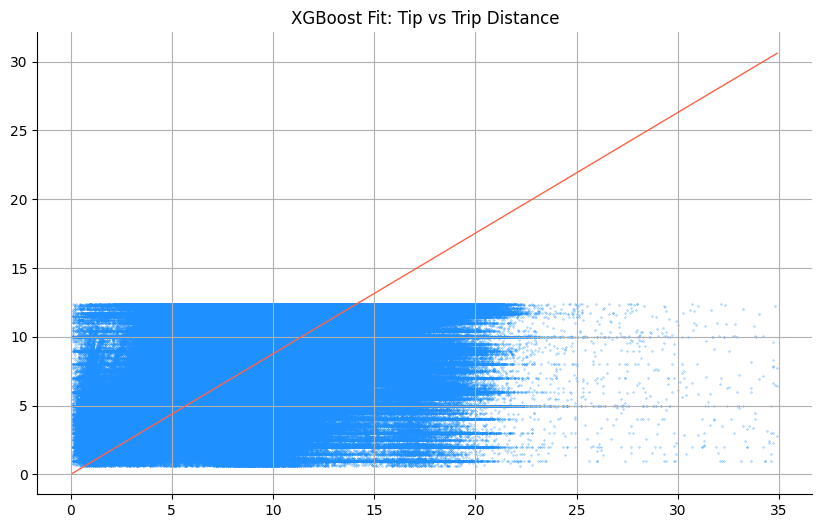

In [127]:
x_line = np.linspace(X['trip_distance'].min(), X['trip_distance'].max(), 500).reshape(-1, 1)
lm_line = linear_model.predict(x_line)

plt.figure(figsize=(10, 6))
plt.scatter(X['trip_distance'], y, marker='x', s=1, alpha=0.3, color='dodgerblue')
plt.plot(x_line, lm_line, color='tomato', linewidth=1)
sns.despine()
plt.title('XGBoost Fit: Tip vs Trip Distance')
plt.grid()

Now consider the mean absolute error for the linear model.

In [21]:
lm_pred = linear_model.predict(X_test)
mean_absolute_error(lm_pred, y_test)

5.938013336010012

Certainly XGBoost performs much better here.

#### Clustering on trip pickup location?

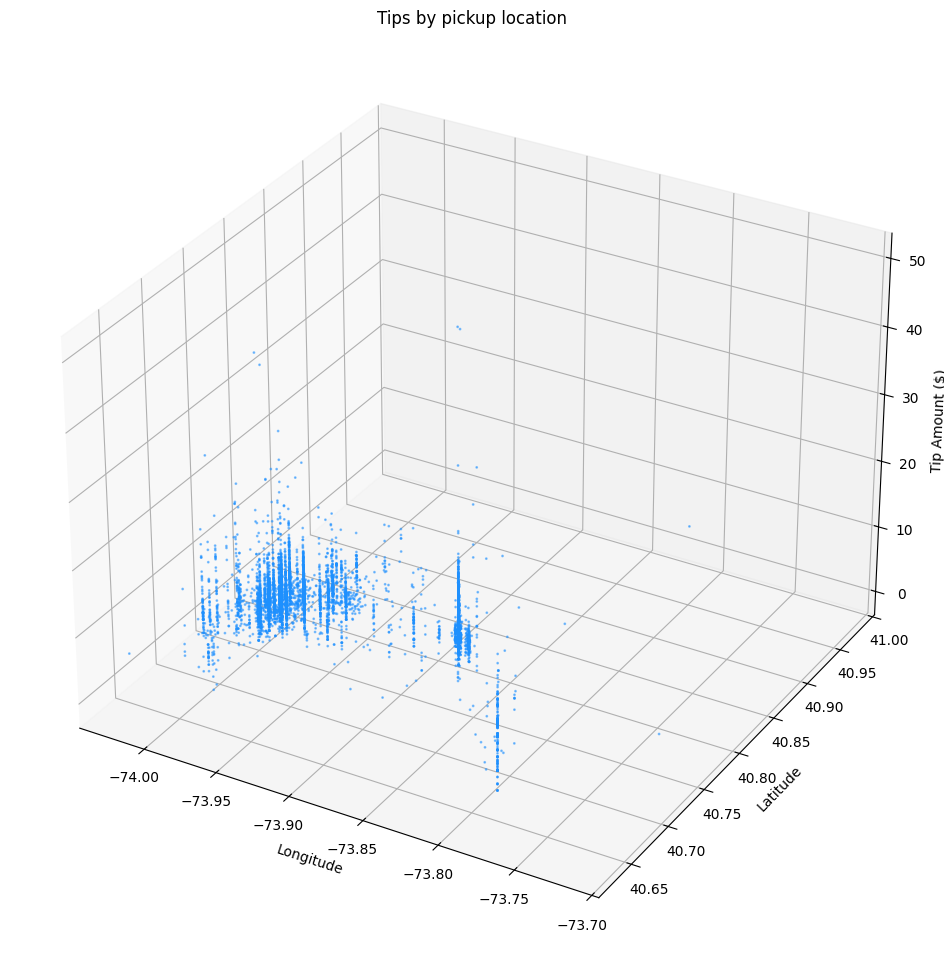

In [87]:
sample_df = data_df.sample(n=10000, random_state=42)
sample_df = sample_df[
    (sample_df['pickup_longitude'] < -73.5)
]

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(sample_df['pickup_longitude'], sample_df['pickup_latitude'], sample_df['tip_amount'], s=1, alpha=0.5, color='dodgerblue')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Tip Amount ($)')
sns.despine()
plt.title('Tips by pickup location')
plt.show()

There doesn't appear to be any specific pickup location specific clustering - particularly since New York City is so dense; I would hypothesise that clustering on the basis of pickup locations is quite difficult.

#### Can passenger count predict tip amount?

Text(0.5, 0, 'Passenger amount')

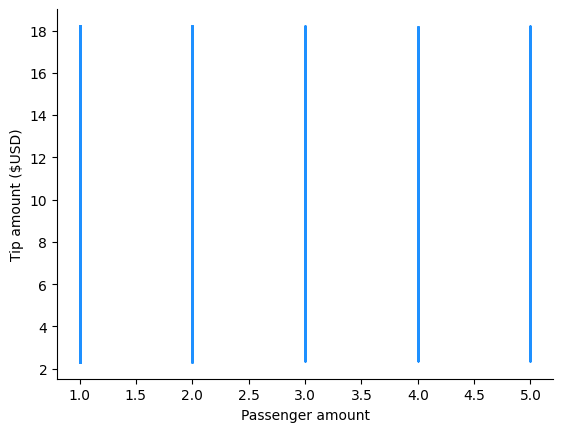

In [81]:
plt.scatter(no_outliers['passenger_count'], no_outliers['tip_amount'], s=1, marker='x', color='dodgerblue')
sns.despine()
plt.ylabel('Tip amount ($USD)')
plt.xlabel('Passenger amount')

We cannot gather much, so we'll get the mean response from these groups to see whether they change.

Text(0.5, 1.0, 'No discernible relationship between passenger count and tip amount')

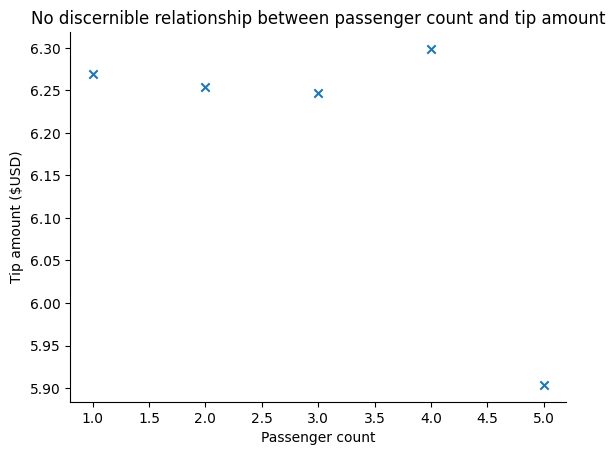

In [35]:
groupby_passengers = no_outliers.groupby('passenger_count')['tip_amount'].mean()
plt.scatter(groupby_passengers.index, groupby_passengers, marker='x')
sns.despine()
plt.xlabel('Passenger count')
plt.ylabel('Tip amount ($USD)')
plt.title('No discernible relationship between passenger count and tip amount')

## How far should we look back for tips?

We consider fitting on one year instead of the global data. Tipping behaviour may change across years, and fitting for global data is of course resource intensive.

In [118]:
date_ptr = '2023-01'
year_data = []

while date_ptr != '2024-01':
    date_data = pd.read_parquet(f'../data/tr_data/{date_ptr}.parquet')
    year_data.append(date_data)
    date_ptr = (pd.to_datetime(date_ptr) + pd.DateOffset(months=1)).strftime('%Y-%m')

year_df = pd.concat(year_data)

In [119]:
# get z-scores of tips
year_df['tip_amount_zscore'] = stats.zscore(year_df['tip_amount'])
no_outliers = year_df[abs(year_df['tip_amount_zscore']) < 2].copy()
no_outliers['trip_distance_bucket'] = pd.cut(no_outliers['trip_distance'], 10).apply(lambda x: (x.left + x.right) / 2)

Text(0.5, 1.0, 'Clearer, positive then bounded relationship seen in one year data v.s global data')

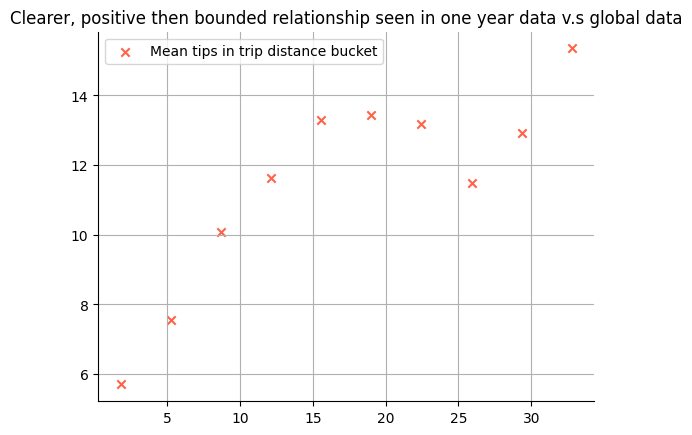

In [80]:
# get bucketed tip amount v.s trip distance
bucket_tips = no_outliers.groupby('trip_distance_bucket', observed=False)['tip_amount'].mean()

plt.scatter(bucket_tips.index, bucket_tips, marker='x', label='Mean tips in trip distance bucket', color='tomato')
sns.despine()
plt.grid()
plt.legend()
plt.title('Clearer, positive then bounded relationship seen in one year data v.s global data')

Now applying the XGBoost fit to the data.

In [ ]:
X_year, y_year = no_outliers[['trip_distance']], no_outliers['tip_amount']

year_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    objective='reg:squarederror',
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X_year, y_year, test_size=0.2)
year_model.fit(X_train, y_train)

Text(0.5, 1.0, 'Year data shows more resilience to outliers')

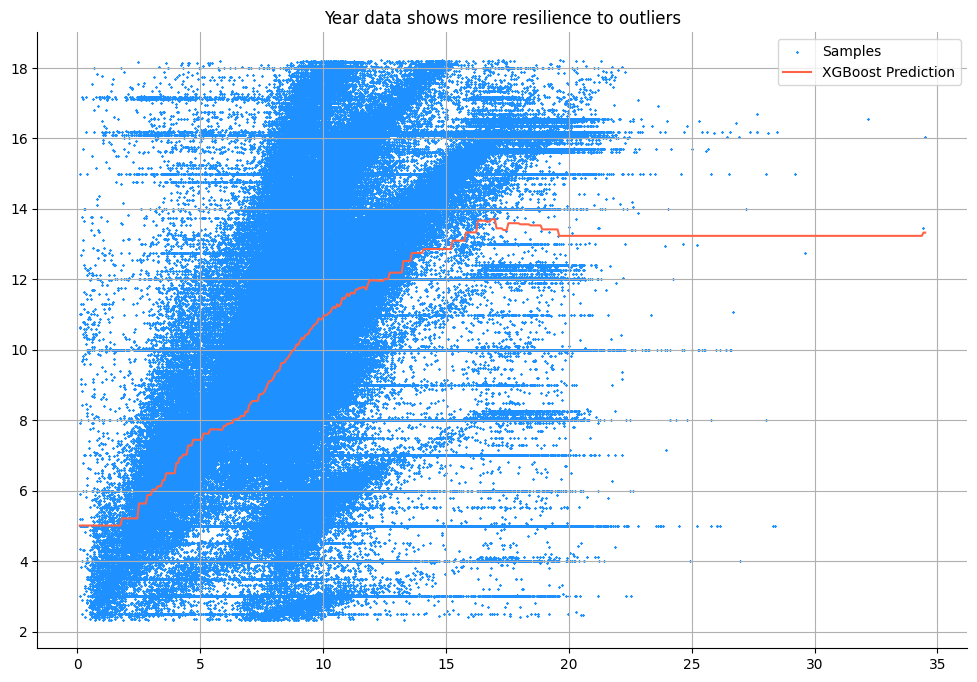

In [79]:
x_input = np.linspace(X_year['trip_distance'].min(), X_year['trip_distance'].max(), 500)
pred_output = year_model.predict(x_input)

plt.figure(figsize=(12, 8))
plt.scatter(X_year, y_year, marker='x', s=1, color='dodgerblue', label='Samples')
plt.plot(x_input, pred_output, color='tomato', label='XGBoost Prediction')
sns.despine()
plt.grid()
plt.legend()
plt.title('Year data shows more resilience to outliers')

So fitting one year of data is sufficient to create an appropiate tip predictor.

## Checking the seasonality of tips

In [60]:
from collections import defaultdict

date_ptr = '2023-01'
month_data = defaultdict()

while date_ptr != '2024-01':
    date_data = pd.read_parquet(f'../data/tr_data/{date_ptr}.parquet')
    date_dt = pd.to_datetime(date_ptr)
    month_data[date_dt.strftime('%B')] = date_data
    date_ptr = (date_dt + pd.DateOffset(months=1)).strftime('%Y-%m')

In [74]:
tip_by_month = []

for month, data in month_data.items():
    tip_by_month.append({
        'month': month,
        'median_tip': data['tip_amount'].median(),
        'mean_tip': data['tip_amount'].mean()
    })

tip_by_month_df = pd.DataFrame(tip_by_month)

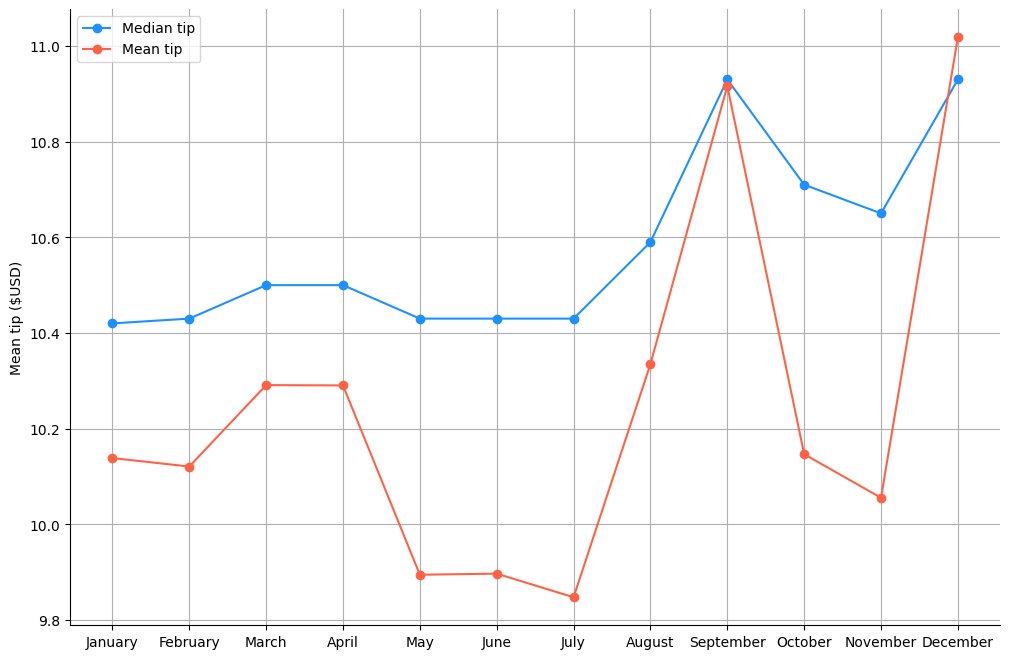

In [78]:
plt.figure(figsize=(12, 8))
plt.plot(tip_by_month_df['month'], tip_by_month_df['median_tip'], 'o-', color='dodgerblue', label='Median tip')
plt.plot(tip_by_month_df['month'], tip_by_month_df['mean_tip'], 'o-', color='tomato', label='Mean tip')
sns.despine()
plt.ylabel('Mean tip ($USD)')
plt.grid()
plt.legend()

There does seem to be a jump in tips during July - September, which is a key time for tourism. We further illuminate whether there exists a deviation in the mean response colouring by group on the original scatter plot.

In [120]:
no_outliers['month'] = no_outliers['pickup_datetime'].dt.month

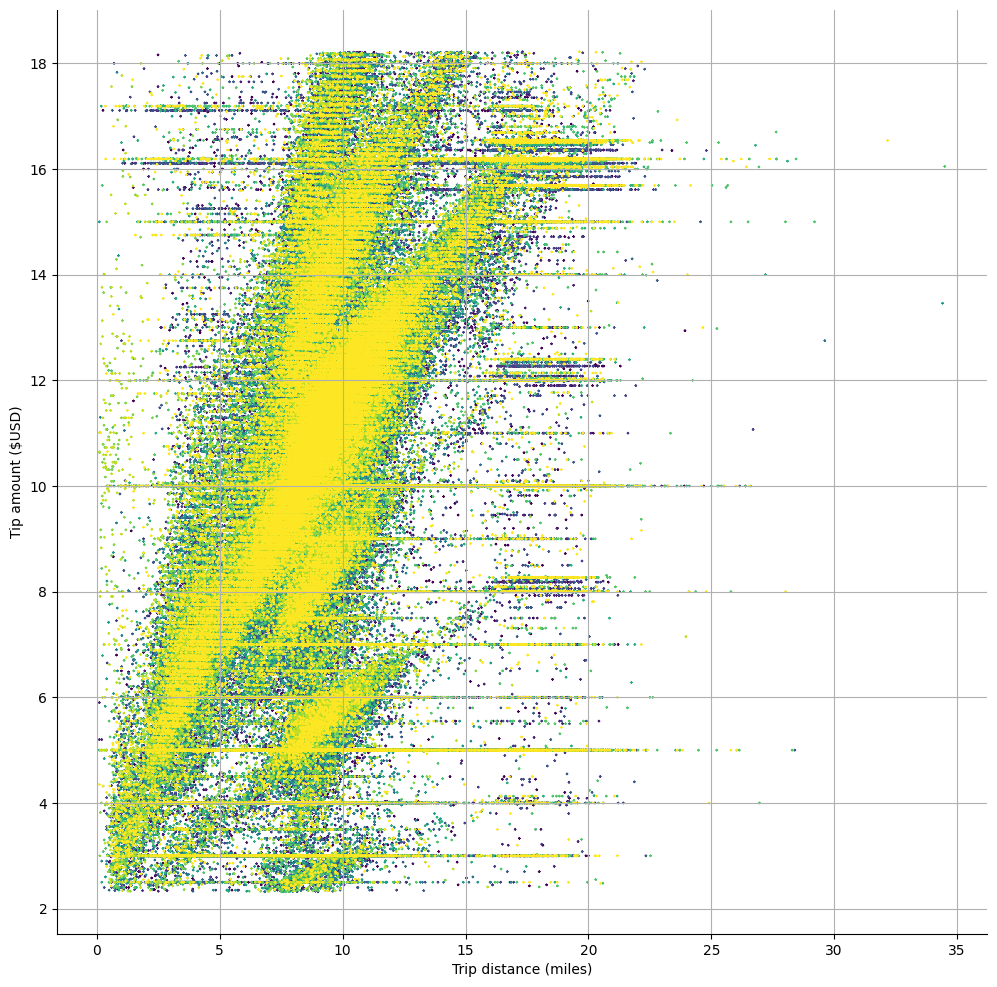

In [122]:
plt.figure(figsize=(12, 12))
plt.scatter(no_outliers['trip_distance'], no_outliers['tip_amount'], c=no_outliers['month'], cmap='viridis', marker='x', s=1)
sns.despine()
plt.ylabel('Tip amount ($USD)')
plt.xlabel('Trip distance (miles)')
plt.grid()

We can't necessarily ascertain a specific band of color which dominates a specific region, but rather a mix of colors in every region. This indicates that doing a per-month or month-aware basis for tip modelling is not worth the work.

However, it does make plausible sense that tips *are* higher during Summer; but the difference in means seems to be so little to not warrant the risk of overfitting.